In [ ]:
import re
import pandas as pd
from scipy.stats import zscore
import numpy as np

# Read data

In [ ]:
df = pd.read_csv("cost_data_set.csv")

# Preprocessing

In [126]:
df = df[df["cost"]<=df["cpc_bid"]]
original_targets = df["cost"]

In [127]:
df = df.drop(['device'],axis=1)
one_hot = pd.get_dummies(df['ad_network_type_2'])
df = df.drop('ad_network_type_2',axis = 1)
df = df.join(one_hot)
df["date"] = pd.to_datetime(df['date'], infer_datetime_format=True).values.astype(np.int64)
tmp_df = df[['date','quality_score', 'clicks', 'position','gdp', 'cpc_bid', 'cost', 'Google search', 'Search partners']]
mean = tmp_df.mean()
std = tmp_df.std()
df[['date','quality_score', 'clicks', 'position','gdp', 'cpc_bid', 'cost', 'Google search', 'Search partners']] = (tmp_df-tmp_df.mean())/tmp_df.std()

In [182]:
df.head()

,date,description,keyword,headline,quality_score,location_target,clicks,position,gdp,cpc_bid,Google search,Search partners,cost
20688,0.102039,8,reseller hosting,Top 10 Reseller Hosting Offers Last Updated: ...,1.251496,43,-0.063852,1.626404,-0.168712,-0.754485,0.243972,-0.243972,-0.680100
5480,-0.420317,23,node js hosting service,Top 10 Nodejs Hosting Services Last Updated: ...,-0.263806,48,-0.063852,0.652328,1.194889,0.094311,0.243972,-0.243972,0.483562
18241,0.408638,23,hosting node js,Top 10 Node.js Hosting Offers Last Updated: {...,1.251496,54,-0.063852,1.464058,0.560656,-0.879959,0.243972,-0.243972,-0.671183
6061,-0.408961,2,low price vps,Top 10 Low Cost VPS Hosting Last Updated: {=m...,1.251496,23,-0.063852,-0.971130,0.999334,-0.164018,0.243972,-0.243972,0.135801
1618,-2.157716,87,vps plan,Top 10 VPS Hosting Plans Compare & Go Live Today,0.241295,31,-0.063852,-0.159401,0.550086,-0.547821,0.243972,-0.243972,-0.532970


In [128]:
targets = pd.Series(df["cost"])
df = df.drop(['cost'],axis=1)

In [129]:
locations = {w:i for i,w in enumerate(df["location_target"].unique())}
for loc,id in locations.items():
    df["location_target"].replace(loc,id,inplace=True)

In [130]:
from collections import Counter

keyword_words = Counter()
for __,s in enumerate(df["keyword"].unique()):
    s = s.split(" ")
    keyword_words.update(s)
keyword_words = dict(filter(lambda x: x[1] > 3, keyword_words.items()))
w2i_keyword = {w:i for i,w in enumerate(keyword_words)}

In [131]:
descriptions = {w:i for i,w in enumerate(df["description"].unique())}
for text,id in descriptions.items():
    df["description"].replace(text,id,inplace=True)

In [132]:
headline_words = Counter()
for __,s in enumerate(df["headline"].unique()):
    s = s.split(" ")
    headline_words.update(s)
headline_words = dict(filter(lambda x: x[1] > 3, headline_words.items()))
w2i_headline = {w:i for i,w in enumerate(headline_words)}

# Neural Network architacture

In [133]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
DESCP_SIZE = len(descriptions)
KEY_SIZE = len(w2i_keyword)
HEAD_SIZE = len(w2i_headline)
LOC_SIZE = len(locations)
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.embedding1 = nn.Embedding(DESCP_SIZE+1,5) #163 + 1
        self.embedding2 = nn.Embedding(KEY_SIZE+1,5) #138 + 1
        self.embedding3 = nn.Embedding(HEAD_SIZE+1,5) #96 + 1
        self.embedding4 = nn.Embedding(LOC_SIZE+1,5) #61 + 1
        self.fc1 = nn.Linear(28,20)
        self.drop1 = nn.Dropout2d(0.05)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(20,10)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(10,1)
    def forward(self,inputs):
        description = self.embedding1(torch.tensor(inputs[1])).view(1,-1)
        keyword = self.embedding2(torch.tensor([w2i_keyword[w] if w in w2i_keyword.keys() else KEY_SIZE for w in inputs[2].split(" ")],dtype=torch.long))
        keyword = torch.mean(keyword,axis=0)
        headline = self.embedding3(torch.tensor([w2i_headline[w] if w in w2i_headline.keys() else HEAD_SIZE for w in inputs[3].split(" ")],dtype=torch.long))
        headline = torch.mean(headline,axis=0)
        location = self.embedding4(torch.tensor(inputs[5])).view(1,-1)
        # concatenating the inputs
        x = torch.cat((torch.Tensor([[inputs[0]]]),description),1)
        x = torch.cat((x,keyword.view(1,-1)),1)
        x = torch.cat((x,headline.view(1,-1)),1)
        x = torch.cat((x,torch.tensor([[inputs[4]]])),1)
        x = torch.cat((x,location),1)
        x = torch.cat((x,torch.Tensor([inputs[6:]])),1)
        # input to neural network
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.out(x)
        return x

In [181]:
df.head()

,date,description,keyword,headline,quality_score,location_target,clicks,position,gdp,cpc_bid,Google search,Search partners,cost
20688,0.102039,8,reseller hosting,Top 10 Reseller Hosting Offers Last Updated: ...,1.251496,43,-0.063852,1.626404,-0.168712,-0.754485,0.243972,-0.243972,-0.680100
5480,-0.420317,23,node js hosting service,Top 10 Nodejs Hosting Services Last Updated: ...,-0.263806,48,-0.063852,0.652328,1.194889,0.094311,0.243972,-0.243972,0.483562
18241,0.408638,23,hosting node js,Top 10 Node.js Hosting Offers Last Updated: {...,1.251496,54,-0.063852,1.464058,0.560656,-0.879959,0.243972,-0.243972,-0.671183
6061,-0.408961,2,low price vps,Top 10 Low Cost VPS Hosting Last Updated: {=m...,1.251496,23,-0.063852,-0.971130,0.999334,-0.164018,0.243972,-0.243972,0.135801
1618,-2.157716,87,vps plan,Top 10 VPS Hosting Plans Compare & Go Live Today,0.241295,31,-0.063852,-0.159401,0.550086,-0.547821,0.243972,-0.243972,-0.532970


# Train

In [134]:
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
model = Model()
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)
loss_values = []
df = pd.concat([df, targets], axis=1)
for epoch in range(10):
    df = shuffle(x)
    total_loss = 0.0
    idx = 0
    print("-------------------epoch {}----------------".format(epoch))
    for _,row in df.iterrows():
        model.zero_grad()
        price = model(row.values[:-1])
        label = torch.Tensor([row.values[-1]])
        loss = loss_function(price,label)
        total_loss += loss
        loss.backward()
        optimizer.step()
        idx += 1
    print("loss: {}".format(total_loss/idx))
    loss_values.append(total_loss/idx)

-------------------epoch 0----------------
loss: 0.2737531065940857
-------------------epoch 1----------------
loss: 0.24179653823375702
-------------------epoch 2----------------
loss: 0.2396104633808136
-------------------epoch 3----------------
loss: 0.23105065524578094
-------------------epoch 4----------------
loss: 0.22656361758708954
-------------------epoch 5----------------
loss: 0.21995915472507477
-------------------epoch 6----------------
loss: 0.21680645644664764
-------------------epoch 7----------------
loss: 0.2137151062488556
-------------------epoch 8----------------
loss: 0.21494747698307037
-------------------epoch 9----------------
loss: 0.21038192510604858


# Loss graph

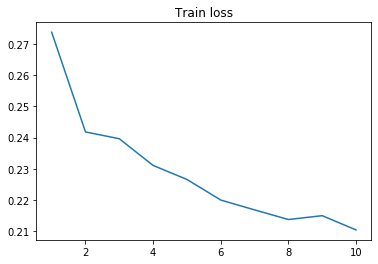

In [180]:
plt.title('Train loss')
plt.plot(range(1,11),loss_values)